<a href="https://colab.research.google.com/github/mauryavikas176/AppliedAI_projects/blob/master/tag_predictor_stackoverflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
  
  
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c facebook-recruiting-iii-keyword-extraction

  0% 0.00/4.81M [00:00<?, ?B/s]
100% 4.81M/4.81M [00:00<00:00, 44.3MB/s]
 99% 715M/725M [00:04<00:00, 195MB/s]
100% 725M/725M [00:04<00:00, 173MB/s]
100% 2.18G/2.19G [00:39<00:00, 28.5MB/s]
100% 2.19G/2.19G [00:39<00:00, 59.5MB/s]


In [ ]:
pip install scikit-multilearn

     |████████████████████████████████| 89 kB 3.1 MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [ ]:
! unzip Train.zip

Archive:  Train.zip
  inflating: Train.csv               


In [ ]:
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv(
        '/content/Train.csv', 
        names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, 
        iterator=True, encoding='utf-8'
    ):
        df.index += index_start
        j += 1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists = 'append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell: ", datetime.now() - start)

180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
Time taken to run this cell:  0:04:24.311925


In [ ]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    print("Number of rows in the database: ","\n",num_rows['count(*)'].values[0])
    con.close()  # Always remember to close the database
    print("Time taken to count the number of rows: ", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database:  
 6034196
Time taken to count the number of rows:  0:00:09.157013


In [ ]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell: ", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell:  0:04:25.941175


In [ ]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [ ]:
print(np.sum(df_no_dup['cnt_dup']))        # Total Number of Questions
print(num_rows['count(*)'].values[0])      # Total Number of Questions
print(df_no_dup.shape[0])                  # Total Number of Unique Questions

6034196
6034196
4206315


In [ ]:
print("Number of duplicate questions: ", num_rows['count(*)'].values[0] - df_no_dup.shape[0],
  "(",(1 - ((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

Number of duplicate questions:  1827881 ( 30.292038906260256 % )


In [ ]:
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [ ]:
df_no_dup.info(show_counts = True)

TypeError: ignored

In [ ]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(
    lambda text: len(text.split(" ")) if text != None else 0 
)

# Adding a new feature number of tags per question
print("Time taken to run this cell: ", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell:  0:00:03.165162


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [ ]:
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
0          7
Name: tag_count, dtype: int64

In [ ]:
if not os.path.isfile('content/train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train', disk_dup)

In [ ]:
if os.path.isfile('/content/train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('/content/train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    # Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.dropna()
    # Printing first 5 rows from our data frame
    tag_data.head()


In [ ]:
tag_data.dropna(axis=0, how='any',inplace=True)


In [ ]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())

In [ ]:
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [ ]:
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [ ]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206308
Number of unique tags : 42048


In [ ]:
# 'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
# Let's look at the tags we have.
print("Some of the tags we have :", tags[:10])


Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


In [ ]:
freqs = tag_dtm.sum(axis = 0).A1
result = dict(zip(tags, freqs))

In [ ]:
if not os.path.isfile('/content/tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("/content/tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [ ]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

In [ ]:
tag_counts

array([331505, 299414, 284103, ...,      1,      1,      1])

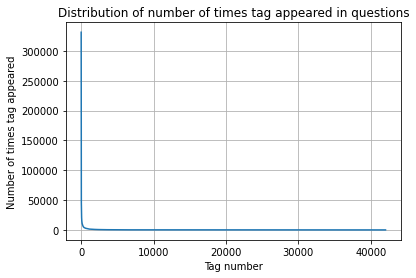

In [ ]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared in questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

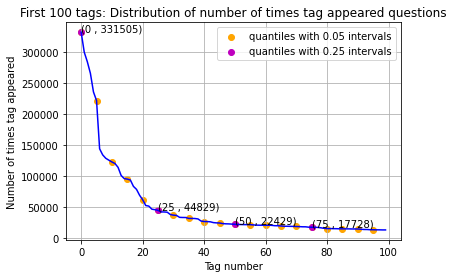

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [ ]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# Quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")
for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('First 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [ ]:
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


In [ ]:
tag_quest_count = tag_dtm.sum(axis=1).tolist()
# Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206308 datapoints.
[2, 3, 4, 2, 2]


In [ ]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899442


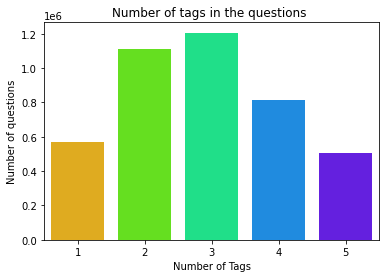

In [ ]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

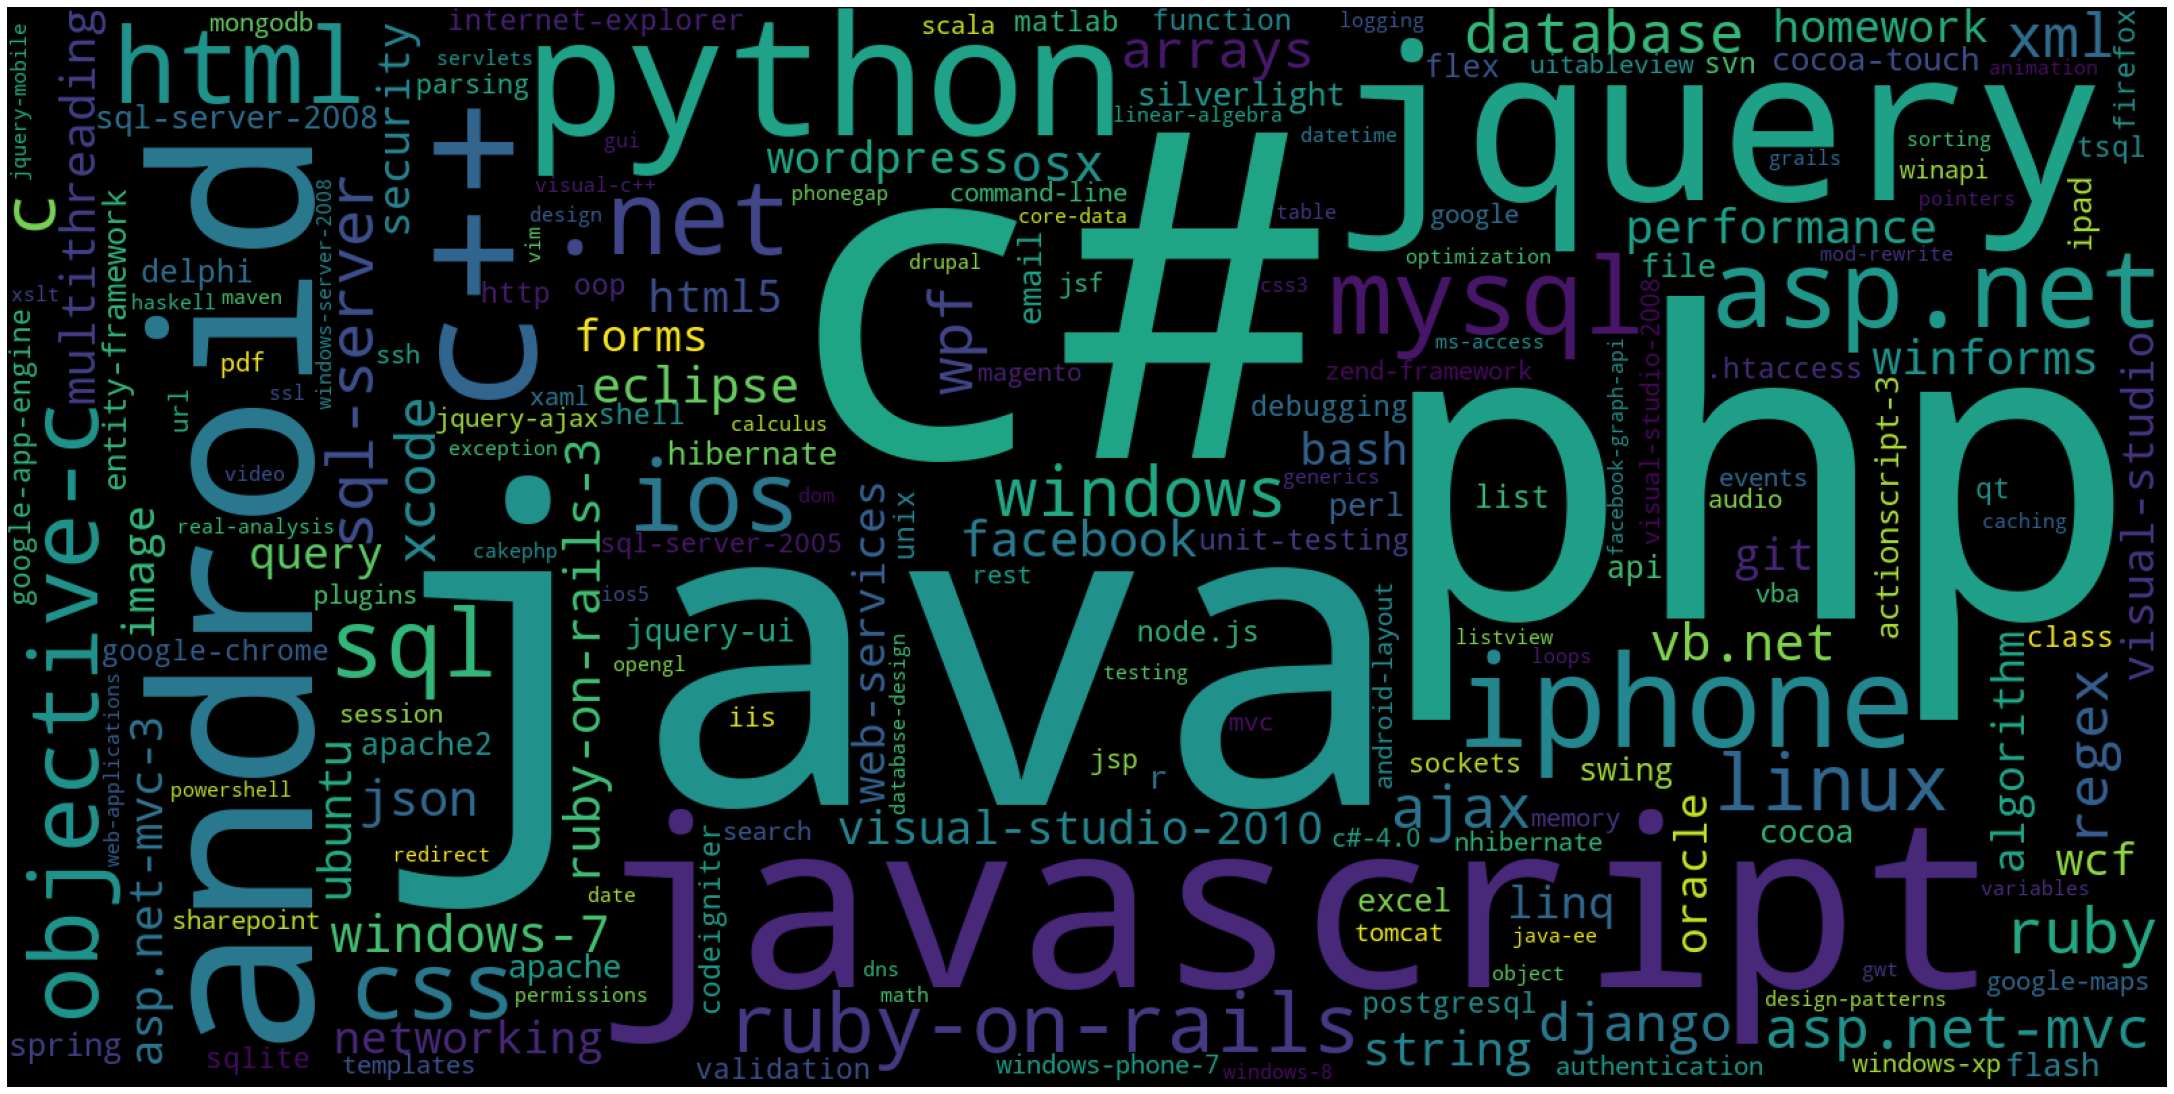

Time taken to run this cell : 0:00:06.079041


In [ ]:
# Plotting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
# Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    
    background_color='black', width=1600, height=800,
).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

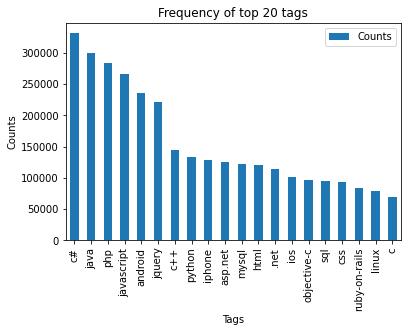

In [ ]:
i = np.arange(20)
tag_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted.head(20)["Tags"])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [ ]:
 import nltk
 nltk.download('stopwords')
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def create_connection(db_file):
    """ 
    Create a database connection to the SQLite database specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None

def create_table(conn, create_table_sql):
    """ 
    Create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables = table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [ ]:
start = datetime.now()
read_db = '/content/train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 100000;")
if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer = conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared all the rows")

print("Time taken to run this cell: ", datetime.now() - start)


Tables in the databse:
QuestionsProcessed
Cleared all the rows
Time taken to run this cell:  0:03:16.185646


In [ ]:
import nltk
nltk.download('punkt')
start = datetime.now()
preprocessed_data_list = []
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_processed = 0
for row in reader:
    is_code = 0
    title, question, tags = row[0], row[1], row[2]
    if '<code>' in question:
        questions_with_code += 1
        is_code = 1
    x = len(question) + len(title)
    len_pre += x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    question = re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question = striphtml(question.encode('utf-8'))
    title = title.encode('utf-8')
    question = str(title) + " " + str(question)
    question = re.sub(r'[^A-Za-z]+',' ',question)
    words = word_tokenize(str(question.lower()))
    # Removing all single letter and stopwords from question except for the letter 'c'
    question=' '.join(
        str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j) != 1 or j == 'c')
    )

    len_post += len(question)
    tup = (question, code, tags, x, len(question), is_code)
    questions_processed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_processed % 10000 == 0):
        print("Number of questions completed = ",questions_processed)

no_dup_avg_len_pre = (len_pre*1.0) / questions_processed
no_dup_avg_len_post = (len_post*1.0) / questions_processed

print("Avg length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print("Avg length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_processed))
print("Time taken to run this cell :", datetime.now() - start)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Number of questions completed =  10000
Number of questions completed =  20000
Number of questions completed =  30000
Number of questions completed =  40000
Number of questions completed =  50000
Number of questions completed =  60000
Number of questions completed =  70000
Number of questions completed =  80000
Number of questions completed =  90000
Avg length of questions(Title+Body) before processing: 1169
Avg length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:02:28.413677


In [ ]:
# Don't forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [ ]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('free memori std vector c vector ad element use push back method get debug assert window trigger breakpoint axcent exe may due corrupt heap indic bug axcent exe dlls load happen call destructor class refer call stack direct follow code block vector class notic error delet vector correct fix refer mani exampl manag work yet quit new c thank lot',)
----------------------------------------------------------------------------------------------------
('access syslistview element qtp tabl element syslistview actual tabl arrang column access rd column tabl syslistview',)
----------------------------------------------------------------------------------------------------
('call crm webservic use crm sdk possibl call crm webservic use crm sdk project access crm webservic access crm web servic logic',)
----------------------------------------------------------------------------------------------------
('know uiview index tag shown uiscrollview uiscrollview lot tag i

In [ ]:
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [ ]:
preprocessed_data.head()

,question,tags
0,spring view control differ map want creat map ...,spring-mvc
1,free memori std vector c vector ad element use...,c++ mfc stdvector
2,access syslistview element qtp tabl element sy...,qtp syslistview32
3,call crm webservic use crm sdk possibl call cr...,dynamics-crm-4
4,know uiview index tag shown uiscrollview uiscr...,cocoa-touch ios uiscrollview


In [ ]:
print("Number of data points in sample: ", preprocessed_data.shape[0])
print("Number of dimensions: ", preprocessed_data.shape[1])

Number of data points in sample:  99997
Number of dimensions:  2


In [ ]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [ ]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn = multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x = multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [ ]:
# Selecting 500 Tags
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

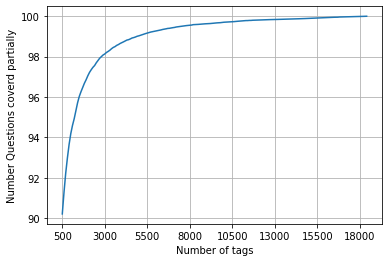

With  5500 tags we are covering  99.165 % of questions
With  500 tags we are covering  90.209 % of questions


In [ ]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("With ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("With ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [ ]:
# We will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("Number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

Number of questions that are not covered : 9791 out of  99997


In [ ]:
total_size = preprocessed_data.shape[0]
train_size = int(0.80*total_size)

x_train = preprocessed_data.head(train_size)
x_test = preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size, : ]
y_test = multilabel_yx[train_size:total_size, : ]

In [ ]:
print("Number of data points in train data:", y_train.shape)
print("Number of data points in test data:", y_test.shape)

Number of data points in train data: (79997, 500)
Number of data points in test data: (20000, 500)


In [ ]:
os.remove("./train.db")

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(
    min_df = 0.00009, max_features = 10000, smooth_idf = True, norm = "l2",
    tokenizer = lambda x: x.split(), sublinear_tf = False, ngram_range = (1,2)
)
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:22.146350


In [ ]:
print("Dimensions of train data X:", x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:", x_test_multilabel.shape, "Y:",y_test.shape)

Dimensions of train data X: (79997, 10000) Y : (79997, 500)
Dimensions of test data X: (20000, 10000) Y: (20000, 500)


In [ ]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

In [ ]:

!pip install joblib --upgrade

In [ ]:
import joblib
joblib.dump(classifier, 'lr.pkl') 

['lr.pkl']

In [ ]:
classifier1 = joblib.load('/content/lr.pkl') 

In [ ]:
predictions = classifier.predict(x_test_multilabel)

In [ ]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

Accuracy : 0.21445
Hamming loss  0.0029133


In [ ]:
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.6976, Recall: 0.3376, F1-measure: 0.4550
Macro-average quality numbers
Precision: 0.5064, Recall: 0.2445, F1-measure: 0.3130


In [ ]:
print (metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.62      0.26      0.37      1589
           1       0.75      0.42      0.54      1377
           2       0.82      0.57      0.67      1403
           3       0.74      0.43      0.54      1229
           4       0.94      0.78      0.85      1133
           5       0.84      0.62      0.71      1035
           6       0.68      0.35      0.47       685
           7       0.86      0.63      0.73       582
           8       0.71      0.44      0.54       633
           9       0.74      0.45      0.56       565
          10       0.84      0.61      0.71       574
          11       0.56      0.21      0.30       552
          12       0.48      0.10      0.16       545
          13       0.61      0.27      0.37       491
          14       0.54      0.28      0.36       447
          15       0.74      0.51      0.60       430
          16       0.51      0.19      0.28       428
          17       0.80    